## Kibot.com 에서 선물일봉 데이터 만들기
 * KibotAPI 이용
 * 단순연결선물 데이터 제공

In [3]:
import sys
sys.path.append('..')
import requests
from collections import defaultdict
import csv
import h5py
import os
import numpy as np
import pandas as pd

In [5]:
#del sys.modules['tools.instruments']

from tools.instruments import instruments
from tools.constants import DATADIR

* 파일 경로:
 - BV: Bakcward ajusted rolled on volume

In [6]:
#REFPATH = os.path.join(DATADIR,'kibot','contracts-list.csv')
CONTRACTSPATH = os.path.join(DATADIR, 'kibot','futures-contracts.hdf')
CONTINUOUSPATH = os.path.join(DATADIR, 'kibot','futures-continuous-BV.hdf')

### 1. 월물 데이터 로드하여 병합하기

In [7]:
#상품별 월물코드 불러오기 (시간순으로 정리되어 있음)
contracts = instruments.kibot_contracts_list()

In [17]:
 def get_quotes_by_symbol(symbol):
    #파일 불러오기 및 월물 리스트 불러오기
    file = h5py.File(CONTRACTSPATH, 'r')
    contracts = instruments.kibot_contracts_list()
    #pandas multi index naming
    names = ['open','high','low','close','volume']
    indexes = [
                sum([ [contract]*5 for contract in contracts[symbol]],[]),
                names*len(contracts[symbol])
            ]

    quotes=[]
    for contract in contracts[symbol]:
        df = pd.DataFrame(file[symbol][contract]['date','open','high','low','close','volume'])
        df['date'] = df['date'].astype('M8[D]')
        df.set_index('date', inplace=True)
        quotes.append(df)

    quotes= pd.concat(quotes, axis=1)
    quotes.columns = indexes

    #첫번째 월물의 거래량이 적어서 오류가 날 가능성이 있음
    #첫번째 월물의 만기 두달전 부터 시작  
    first_contract = contracts[symbol][0]
    m = instruments.month_code(first_contract[-3])
    m = f'{[1,2,3,4,5,6,7,8,9,10,11,12][m-3]:02d}'
    y = '20'+str(first_contract[-2:])
    startdate = y+'-'+m+'-'+'01'
    quotes = quotes[startdate:]
    
    return quotes

### 2. 연결선물데이터 만들기
* 연결방법: Backward Panama Ajusted
* 연결기준:
    1. Roll on volume change: 거래량이 역전된 다음 날 기준
    2. Roll on open interest: 미결제 약정 계약수가 역전된 다음날 기준

In [276]:
def create_continuous_futures(symbol):
    quotes = get_quotes_by_symbol(symbol)
    volumes = quotes.xs('volume',axis=1,level=1)
    columns = volumes.columns
    active = 0
    rolls = []
    #액티브월물, 인덱스(숫자), 가격차, 날짜
    rolls.append((columns[active], 0, 0, quotes.index[0])) 
    """
    * 액티브 월물 선택 규칙
     1. 액티브월물이 현재보다 앞선 월물로 바뀌지 않는다. 
     2. 현재 액티브월물 포함 연속된 4개의 월물중 거래량이 가장 많은 월물로 변경한다.
     3. 연속된 4개의 월물이 모두 nan 이면 스킵한다 
     4. 현재 액티브 월물이 nan이고 다음 3개월물 값이 있으면 그 중 거래량이 가장 많은 월물로 변경한다. 
    """
    for date, row in volumes.iloc[1:].iterrows():
        flag = row[active:active+4]

        # 연속된 4개월물이 모두 nan 이면 스킵 
        # 가끔 nan + 0 이 들어있어서 그것도 스킵
        if pd.isna(flag.max()) or flag.max() == 0:
            #print('11111', volumes.columns[active])
            continue

        maxcol = columns.get_loc(flag.idxmax())
        
        # 신규월물이 액티브월물보다 앞선 월물이면 스킵
        if maxcol <= active:
            #print("%%% 앞선월물로 변경 중", flag.idxmax(), date)
            continue

        else:
            #print(f"월물변경: {columns[active]} -> {columns[idxmax]} ({date}) {instruments.month_code(flag.idxmax()[-3])}")
            idx = volumes.index.get_loc(date) #월물 변경날 인덱스
            
            before_price = quotes[columns[active]].iloc[idx-1]['close']
            after_price = quotes[columns[maxcol]].iloc[idx-1]['close'] 
            
            if pd.isna(after_price) or pd.isna(after_price):
                #raise ValueError('nan 값 발생', date, columns[active])
                before_price = quotes[columns[active]].iloc[idx]['close']
                after_price = quotes[columns[maxcol]].iloc[idx]['close']
                    
                if pd.isna(after_price) or pd.isna(after_price):
                    raise ValueError('nan 값 발생', date, columns[active])

            
            diff = after_price - before_price
            #print(quotes[columns[active]].loc[date]['close'], idx, diff)
            active = maxcol
            rolls.append((columns[active], idx, diff, date))
    

    # 롤오버 정보 정리하기
    rollinfo = []
    #diff = 0
    for i in range(len(rolls)):
        if i == len(rolls)-1:
            end = None
        else:
            end = rolls[i+1][1]-1
        # 월물이름, 시작인덱스(숫자), 끝인덱스(숫자), 가격차, 날짜
        rollinfo.append((rolls[i][0], rolls[i][1], end, rolls[i][2], rolls[i][3]))
        
    # 데이터 합치기 
    start = rollinfo[0]
    df = quotes[start[0]].iloc[start[1]:start[2]]
    for row in rollinfo[1:]:
        df[['open','high','low','close']] = df[['open','high','low','close']]+ row[3]
        df = pd.concat([df, quotes[row[0]].iloc[row[1]:row[2]]])
        df.dropna(inplace=True) #nan value 포함한 행 삭제
    return df, rollinfo

### 3. 데이터 저장하기
- data/kibot/futures-continuous-BV.hdf 에저장

In [171]:
from numpy.lib.recfunctions import unstructured_to_structured

In [277]:
file = h5py.File(CONTINUOUSPATH, 'w')

In [278]:
contracts = instruments.kibot_contracts_list()
for symbol in contracts.keys():
    print(f"[{symbol}] {instruments[symbol].name} 진행중..")
    df, rollinfo = create_continuous_futures(symbol)
    
    # numpy array 만들기 
    dtypes= np.dtype([
        ('date', 'i'),
        ('open', 'f'),
        ('high','f'),
        ('low','f'),
        ('close','f'),
        ('volume', 'i'),
        ('open_interest','i')
    ])

    df['open_interest'] = 0
    date = df.index.values.astype('M8[D]').astype('i')
    date = date.reshape((date.shape[0],1))
    quotes = df.values
    arr = np.hstack((date,quotes))
    datalist = [ tuple(row) for row in arr]
    file.create_dataset(symbol, data=np.array(datalist, dtypes))
print("DONE")

[AD] CME Australian Dollar AUD 진행중..
[BO] CBOT Soybean Oil 진행중..
[BP] CME British Pound GBP 진행중..
[C] CBOT Corn 진행중..
[CD] CME Canadian Dollar CAD 진행중..
[CL] NYMEX WTI Crude Oil 진행중..
[MD] CME S&P 400 Midcap Index 진행중..
[ES] CME S&P 500 Index E-Mini 진행중..
[EC] CME Euro FX 진행중..
[FV] CBOT 5-year US Treasury Note 진행중..
[GC] NYMEX Gold 진행중..
[LN] CME Lean Hogs 진행중..
[HG] COMEX Copper 진행중..
[JY] CME Japanese Yen JPY 진행중..
[LE] CME Live Cattle 진행중..
[NE] CME New Zealand Dollar NZD 진행중..
[NG] NYMEX Natural Gas 진행중..
[NK] CME Nikkei 225 진행중..
[NQ] CME NASDAQ 100 Index Mini 진행중..
[O] CBOT Oats 진행중..
[PA] NYMEX Palladium 진행중..
[PL] NYMEX Platinum 진행중..
[RR] CBOT Rough Rice 진행중..
[RTY] CME Russell 2000 Index Mini 진행중..
[S] CBOT Soybeans 진행중..
[SF] CME Swiss Franc CHF 진행중..
[SI] NYMEX Silver 진행중..
[SM] CBOT Soybean Meal 진행중..
[TU] CBOT 2-year US Treasury Note 진행중..
[TY] CBOT 10-year US Treasury Note 진행중..
[US] CBOT 30-year US Treasury Bond 진행중..
[VX] CBOE VIX Futures 진행중..
[W] CBOT Wheat 진행중..
[Y

In [279]:
file.close()

### 4. 데이터 검증

In [280]:
file = h5py.File(CONTINUOUSPATH, 'r')

In [291]:
df = pd.DataFrame(file['W'][:])

In [292]:
df['date'] = df['date'].astype('M8[D]')

In [293]:
df.set_index('date', inplace=True)

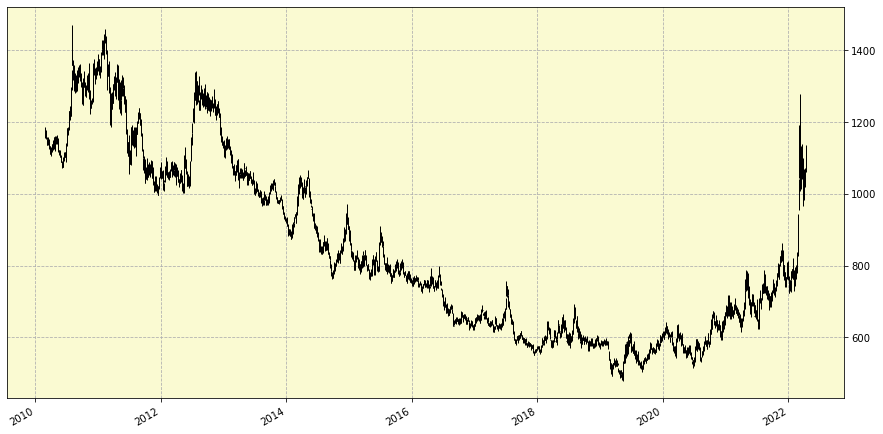

In [297]:
view(df, size=(15,8))